In [1]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Register matplotlib converters
register_matplotlib_converters()

In [2]:
# Load the dataset
df = pd.read_csv('C:/Users/moham/Desktop/itemFour.csv')

In [3]:
# Filter and format the data for store 1 and item 4
df = df[(df['store'] == 1) & (df['item'] == 4)]
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
df.set_index('date', inplace=True)

# Create additional date features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])

# Split the data into training and testing sets
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]

In [4]:
# Define a function to test stationarity
def test_stationarity(timeseries):
    # Calculate rolling statistics
    rollmean = timeseries.rolling(window=30).mean()
    rollstd = timeseries.rolling(window=30).std()

    # Plot original series and rolling statistics
    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

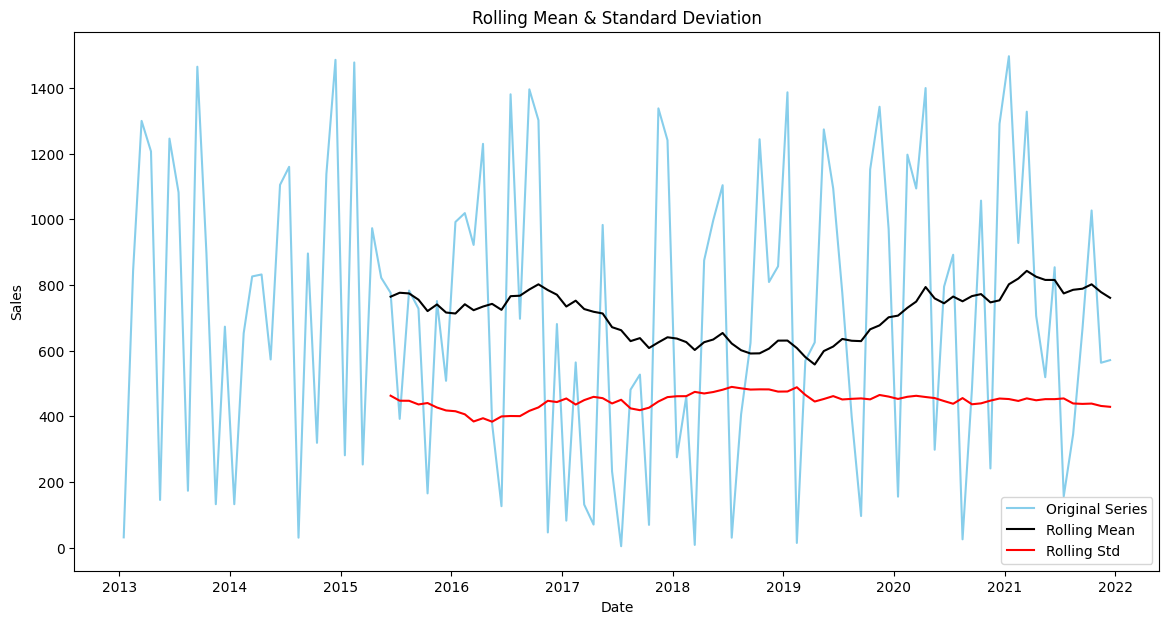

Test statistic = -10.797
P-value = 0.000
Critical values :
	1%: -3.492995948509562 - The data is  stationary with 99% confidence
	5%: -2.888954648057252 - The data is  stationary with 95% confidence
	10%: -2.58139291903223 - The data is  stationary with 90% confidence


In [5]:
# Test stationarity on the sales column of train_df
test_stationarity(train_df['sales'])

In [6]:
# Fit an ARIMA model
arima_model61 = ARIMA(train_df['sales'], order=(6, 1, 1)).fit()
print(arima_model61.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  108
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -804.831
Date:                Fri, 01 Dec 2023   AIC                           1625.662
Time:                        21:59:07   BIC                           1647.044
Sample:                             0   HQIC                          1634.330
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0110      0.101     -0.109      0.913      -0.209       0.187
ar.L2         -0.0720      0.107     -0.674      0.500      -0.281       0.137
ar.L3          0.0323      0.097      0.334      0.7

In [7]:
# Fit a SARIMAX model
sarima_model = SARIMAX(train_df['sales'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

# Generate forecasts for the test dataset
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean

# Ensure that indices of pred_sales and test_df are aligned
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales

In [8]:
# Calculate errors
test_df['errors'] = test_df['sales'] - test_df['pred_sales']

# Define error metrics
def mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred) ** 2))
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

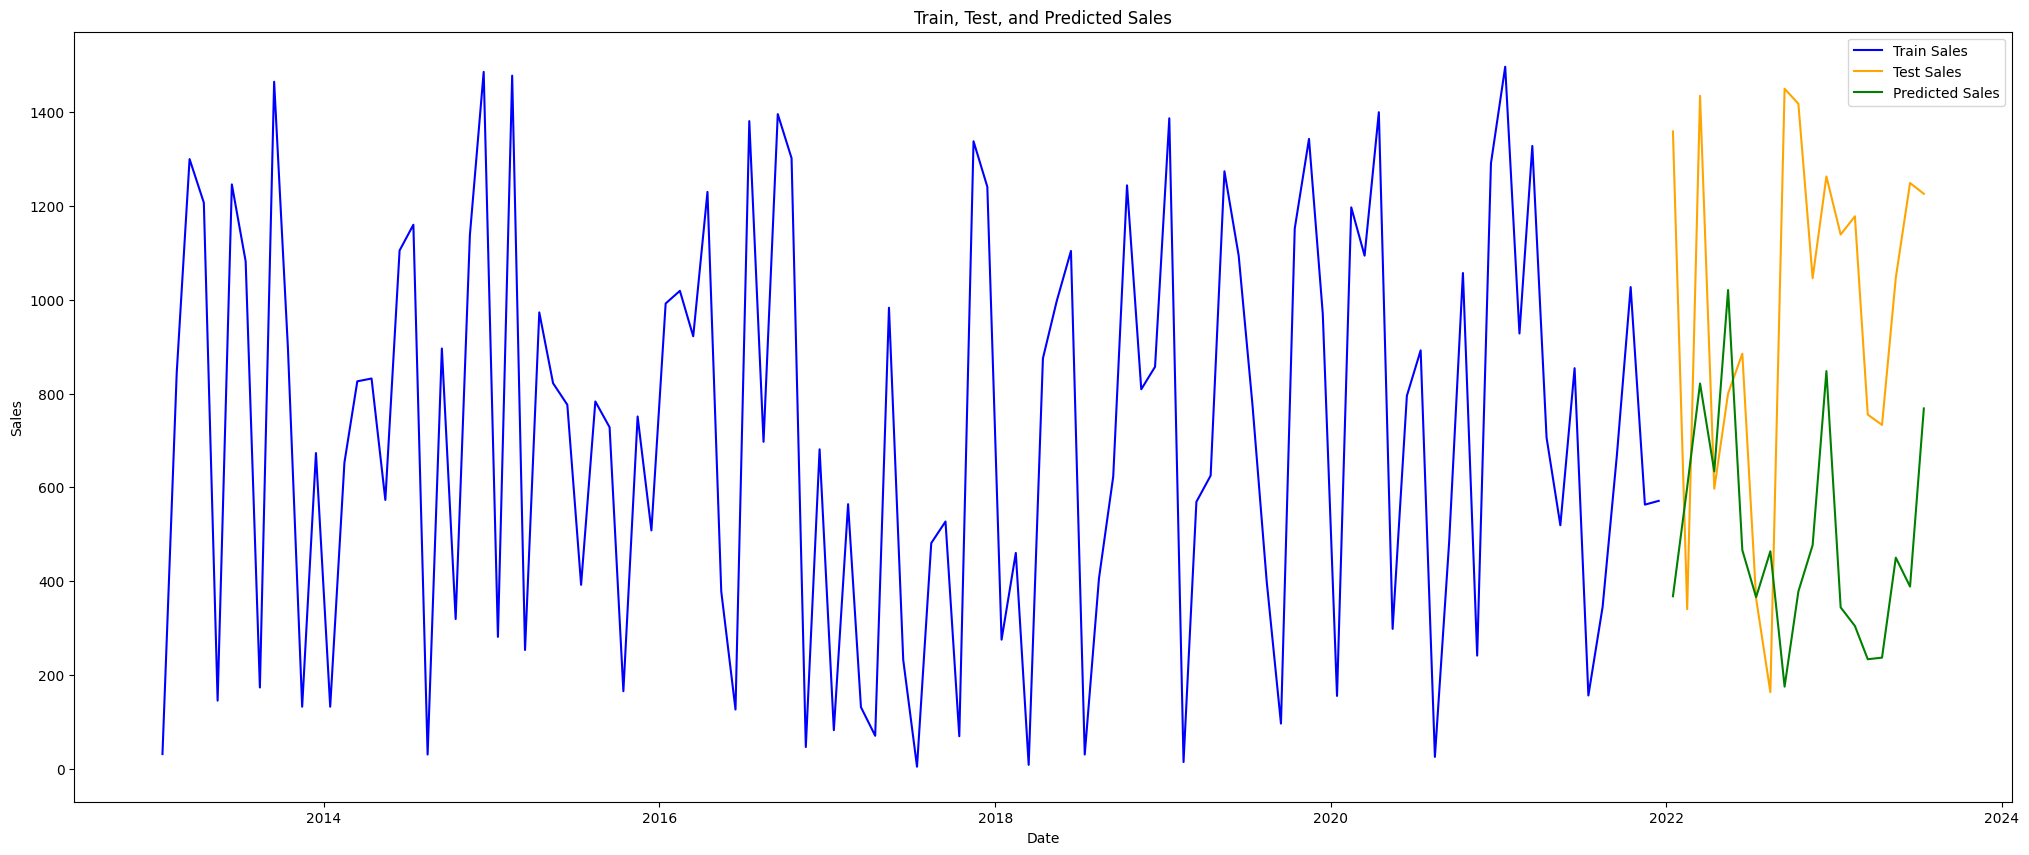

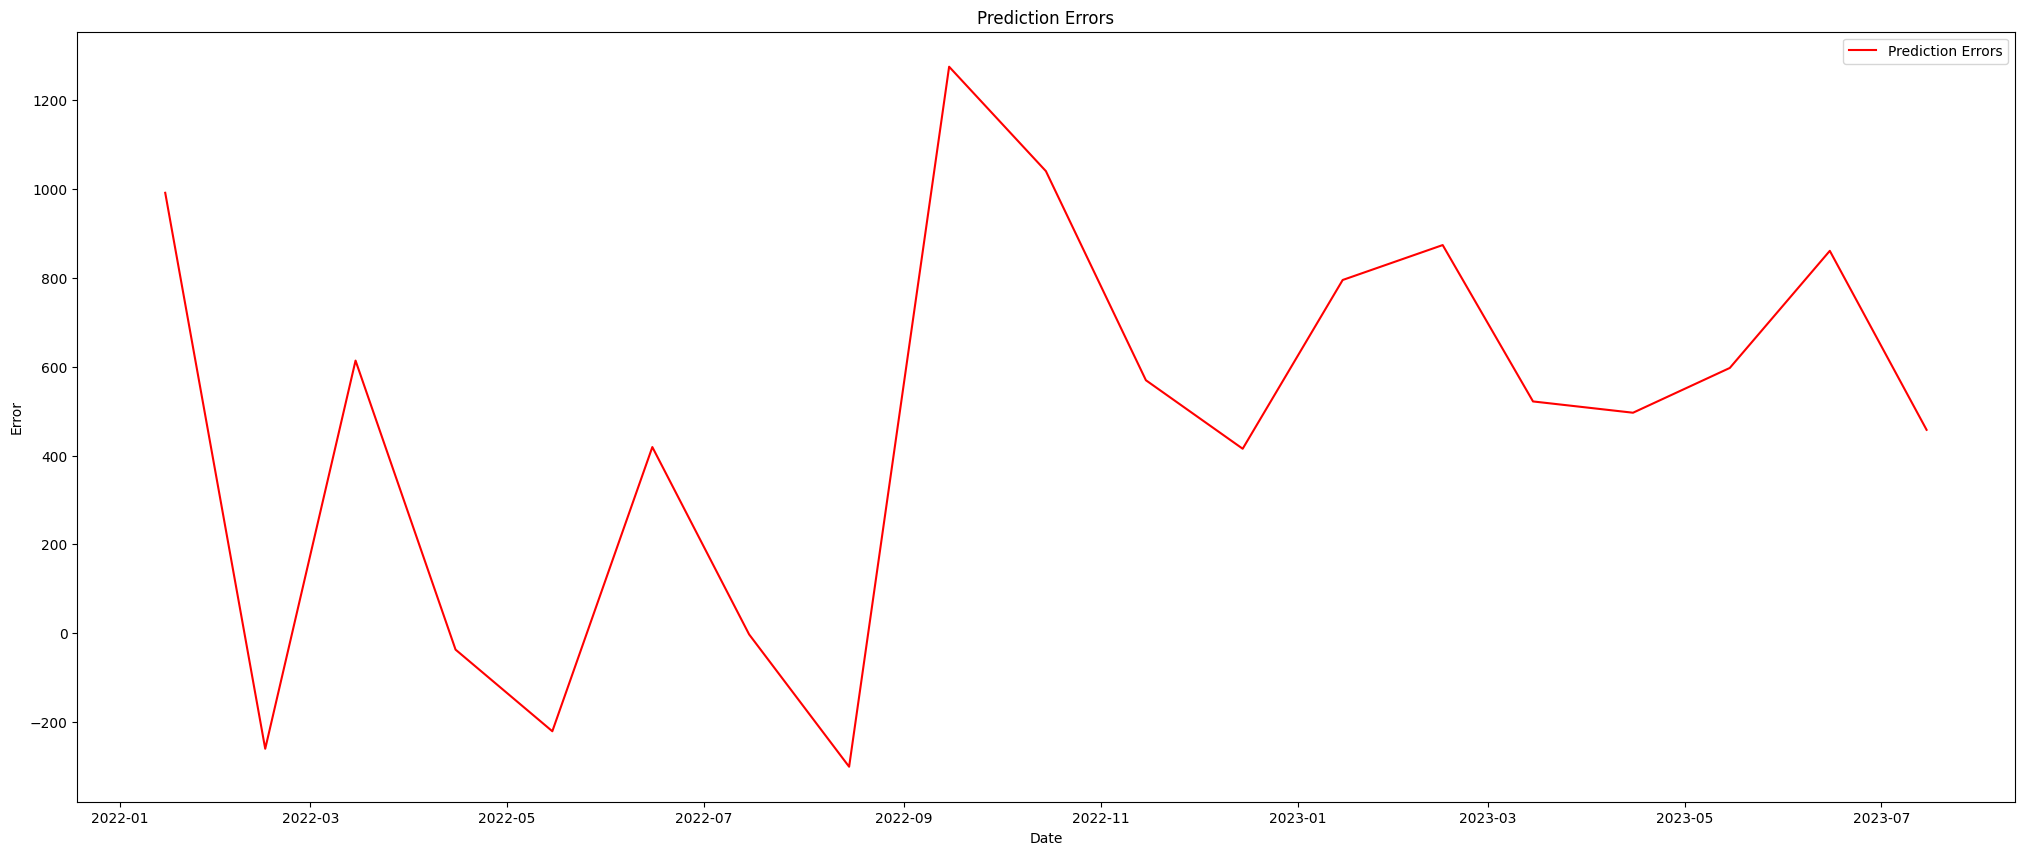

In [9]:
# Plotting the forecast and errors
plt.figure(figsize=(25,10))
plt.plot(train_df.index, train_df['sales'], label='Train Sales', color='blue')
plt.plot(test_df.index, test_df['sales'], label='Test Sales', color='orange')
plt.plot(test_df.index, test_df['pred_sales'], label='Predicted Sales', color='green')
plt.title('Train, Test, and Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(25,10))
plt.plot(test_df.index, test_df['errors'], label='Prediction Errors', color='red')
plt.title('Prediction Errors')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

In [10]:
# Aggregate results
result_df_sarima = pd.DataFrame({
    'total_sales': [test_df['sales'].sum()],
    'total_pred_sales': [test_df['pred_sales'].sum()],
    'SARIMA_overall_error': [test_df['errors'].sum()],
    'MAE': [mae(test_df['sales'], test_df['pred_sales'])],
    'RMSE': [rmse(test_df['sales'], test_df['pred_sales'])],
    'MAPE': [mape(test_df['sales'], test_df['pred_sales'])]
})
result_df_sarima

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
0,18446,9339.941743,9106.058257,565.685689,655.725464,60.589104
